# Предсказание выходной температуры сплава при плавке стали 

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Кратко, процесс плавки представляет собой замер температуры, нагревание сплава электродами, добавление примесей, продувка газом и снова замер температуры. Процесс повторяется необходимое количество раз.  

**Цель работы:**  
Создать модель прогнозирования температуры сплава на последней итерации цикла плавки (задача регрессии). Исходные данные - техническая информация(циклы нагрева и мощность электродов, информация о примесях, продувке газом и пр.) для чуть более 3000 циклов плавки.  
Метрика качества - MAE. Она должна быть не выше 6.8.

**Ход работы**
1. Исследование данных
2. Предобработка данных
3. Выбор и исследование нескольких моделей машинного обучения
4. Тестирование наиболее подходящей модели
5. Создание отчета по итогам проведенной работы

# Исследование данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     cross_val_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

In [2]:
RANDOM_STATE = 110923

Импортируем наши датасеты

In [3]:
try:
    data_arc = pd.read_csv('data_arc_new.csv')
    data_bulk = pd.read_csv('data_bulk_new.csv')
    data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')

except:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

Посмотрим на каждый из датасетов

## Data_arc

`data_arc` - это датасет с данными об электродах, которые опускают в ковш, для плавки находящегося в нем стального сплава

### Общая информация о датасете

In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


---
Явные пропуски в датасете отсутсвуют, во всех колонках 14876 значений.  
`key` - это номер партии. Если есть несколько строк с одинаковым значением key, то это разные циклы обработки.  
Если смотреть на описательные статистики, то сразу заметно отрицательное значение в поле `Реактивная мощность`. Дальше, как раз взглянем на столбцы с мощностью подробнее.  
Также, на этапе предобработке можно будет сгенерировать новые признаки: длительность нагрева, полную мощность и энергию.

### Смотрим признаки

**Активная мощность**

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


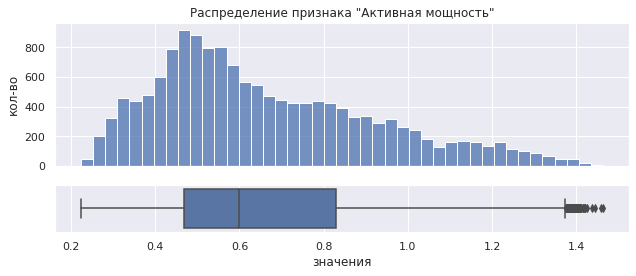

In [7]:
sns.set_theme()
fig, axes = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 4))
sns.histplot(data_arc['Активная мощность'], ax=axes[0])
sns.boxplot(data_arc['Активная мощность'], orient='h', ax=axes[1])
axes[0].set(title='Распределение признака "Активная мощность"')
axes[0].set(ylabel='кол-во')
axes[1].set(xlabel='значения')
plt.tight_layout()

Распределение похоже на нормальное, со смещением вправо. Аномалий или аномальных пиков на графиике нет.  
На диаграмме размаха есть значения, которые можно посчитать выбросами. Но точно сказать, выбросы это или технологическая норма нельзя, да и находятся они не так уж и далеко от границы "уса". Поэтому, будем считать их нормой

**Реактивная мощность**

Чтобы графики сильно не смещались из-за аномальных значений, исследуем их отдельно. В нашем случае, это отрицательные значения

In [8]:
print('Отрицательных значений:', len(data_arc[data_arc['Реактивная мощность'] < 0]))

Отрицательных значений: 1


Отлично, можно смело строить графики без этого выброса

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


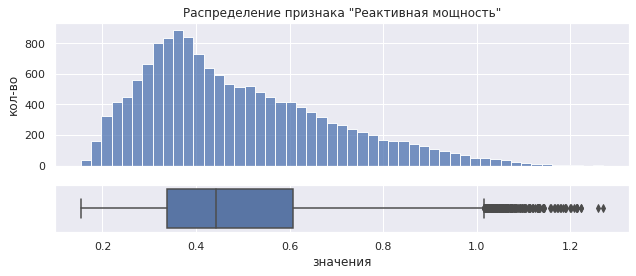

In [9]:
#уберем выброс, чтобы графики нормально отображались
data_react = data_arc[data_arc['Реактивная мощность'] > 0]

fig, axes = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(9, 4))
sns.histplot(data_react['Реактивная мощность'], ax=axes[0])
sns.boxplot(data_react['Реактивная мощность'], orient='h', ax=axes[1])
axes[0].set(title='Распределение признака "Реактивная мощность"')
axes[0].set(ylabel='кол-во')
axes[1].set(xlabel='значения')
plt.tight_layout()

Получили распределение, близкое к нормальному со смещением вправо. Выброс всего один - отрицательное значение. Данные, лежащие за границей правого "уса" выбросами считать не будем.

## Data_bulk

`data_bulk` - это датасет с данными о подаче сыпучих материалов (объём)

### Общая информация о датасете

In [10]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Имеем от заказчика информацию - отсутствующие значения можно считать нулевыми(то есть, материал не добавлялся)  
Думаю, не очень целесообразно рассматривать признаки, где нулевых значений слишком много. Возьмем только те столбцы, где больше 1000 значений.

In [11]:
bulk_selected = ['Bulk 3', 'Bulk 4', 'Bulk 12', 'Bulk 14', 'Bulk 15']

In [12]:
data_bulk[bulk_selected].head()

,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
0,NaN,43.0,206.0,150.0,154.0
1,NaN,73.0,206.0,149.0,154.0
2,NaN,34.0,205.0,152.0,153.0
3,NaN,81.0,207.0,153.0,154.0
4,NaN,78.0,203.0,151.0,152.0


In [13]:
data_bulk[bulk_selected].describe()

,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
count,1298.000000,1014.000000,2450.000000,2806.000000,2248.000000
mean,113.879045,104.394477,260.471020,170.284747,160.513345
std,75.483494,48.184126,120.649269,65.868652,51.765319
min,6.000000,12.000000,53.000000,16.000000,1.000000
25%,58.000000,72.000000,204.000000,119.000000,105.000000
50%,97.500000,102.000000,208.000000,151.000000,160.000000
75%,152.000000,133.000000,316.000000,205.750000,205.000000
max,454.000000,281.000000,1849.000000,636.000000,405.000000


В столбце `Bulk 12` видны выбивающиеся высокие значения. Если таких значений мало, исключим их при постройке графика

In [14]:
print('Аномальных значений:', len(data_bulk[data_bulk['Bulk 12'] > 800]))

Аномальных значений: 3


### Смотрим признаки

In [15]:
data_bulk12 = data_bulk[data_bulk['Bulk 12'] < 800]

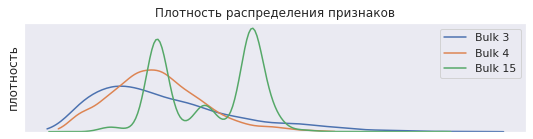

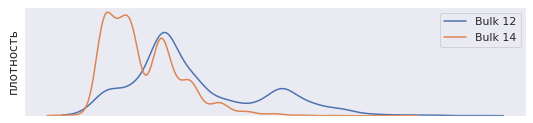

In [16]:
plt.figure(figsize=(9, 2))
plt.title('Плотность распределения признаков')
fig = sns.kdeplot(data_bulk['Bulk 3'], cut=True)
fig = sns.kdeplot(data_bulk['Bulk 4'], cut=True)
fig = sns.kdeplot(data_bulk['Bulk 15'], cut=True)
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('плотность')
plt.legend(labels=['Bulk 3', 'Bulk 4', 'Bulk 15'])
plt.show()
plt.figure(figsize=(9, 2))
fig = sns.kdeplot(data_bulk12['Bulk 12'], cut=True)
fig = sns.kdeplot(data_bulk['Bulk 14'], cut=True)
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('плотность')
plt.legend(labels=['Bulk 12', 'Bulk 14'])
plt.show()

Видно, что признаки распределены по-разному, но у всех есть смещение вправо.  
Выбросами будем считать только несколько экстремально высоких значений стобца `Bulk 12`

## Data_gas

`data_gas` - это датасет с данными о продувке сплава газом

In [17]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [18]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [19]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [20]:
print('Аномальных значений:', len(data_gas[data_gas['Газ 1'] >= 40]))

Аномальных значений: 8


In [21]:
data_gas_selected = data_gas[data_gas['Газ 1'] < 40]

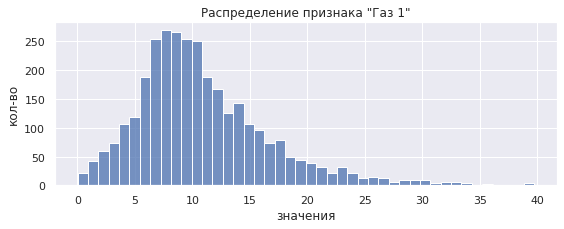

In [22]:
plt.figure(figsize=(9, 3))
sns.histplot(data_gas_selected['Газ 1'])
plt.xlabel('значения')
plt.ylabel('кол-во')
plt.title('Распределение признака "Газ 1"')
plt.show()

Получили распределение без аномалий

## Data_temp

`data_temp` - это датасет с результатами измерения температуры сплава в ковше

In [23]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [24]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Записи с одинаковым значением поля `key` - это разные итерации одного цикла плавки.  
Температура на первой итерации можеть быть признаком для обучения.  
Температура на последней итерации - таргет

In [25]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


От заказчика знаем, что температуру ниже ~1450 можем считать дефектом измерения, так как плавка сплава при такой температуре невозможна

In [26]:
data_temp_selected = data_temp[data_temp['Температура'] > 1450]

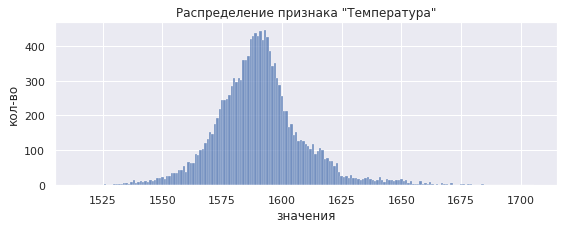

In [27]:
plt.figure(figsize=(9, 3))
sns.histplot(data_temp_selected['Температура'], discrete=True)
plt.xlabel('значения')
plt.ylabel('кол-во')
plt.title('Распределение признака "Температура"')
plt.show()

## Data_wire

`data_wire` - это датасет с данными о подаче проволочных материалов (объём)

In [28]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Как и в случае с сыпучими материалами имеем информацию от заказчика, что отсутствующие значения можно заполнить нулями.  
Рассмотрим только те столбцы, где значений больше 1000

In [29]:
data_wire[['Wire 1', 'Wire 2']].head()

,Wire 1,Wire 2
0,60.059998,NaN
1,96.052315,NaN
2,91.160157,NaN
3,89.063515,NaN
4,89.238236,9.11456


In [30]:
data_wire[['Wire 1', 'Wire 2']].describe()

,Wire 1,Wire 2
count,3055.000000,1079.000000
mean,100.895853,50.577323
std,42.012518,39.320216
min,1.918800,0.030160
25%,72.115684,20.193680
50%,100.158234,40.142956
75%,126.060483,70.227558
max,330.314424,282.780152


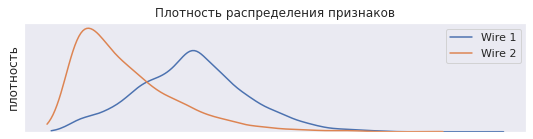

In [31]:
plt.figure(figsize=(9, 2))
plt.title('Плотность распределения признаков')
fig = sns.kdeplot(data_wire['Wire 1'], cut=True)
fig = sns.kdeplot(data_wire['Wire 2'], cut=True)
plt.xticks([])
plt.xlabel('')
plt.yticks([])
plt.ylabel('плотность')
plt.legend(labels=['Wire 1', 'Wire 2'])
plt.show()

Получили распределения без аномалий

## Data_bulk_time и data_wire_time

`data_bulk_time` и `data_wire_time` - это датасет с временем добавления сыпучих и проволочных материалов соответственно

In [32]:
data_bulk_time.sample(5, random_state=RANDOM_STATE)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
435,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-21 03:31:46,NaN,2019-05-21 03:25:53,NaN,2019-05-21 03:18:46,2019-05-21 02:13:39
673,705,NaN,NaN,2019-05-31 00:03:29,2019-05-30 23:55:55,NaN,2019-05-30 23:50:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-30 23:38:26,NaN
1511,1569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-01 12:01:41,NaN,2019-07-01 11:57:58,2019-07-01 11:32:28
2973,3082,NaN,NaN,2019-09-01 06:42:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 06:52:52,NaN,2019-09-01 06:49:35,2019-09-01 06:42:21
2526,2622,NaN,NaN,2019-08-15 03:06:59,NaN,NaN,2019-08-15 03:36:05,NaN,NaN,NaN,NaN,2019-08-15 03:24:52,NaN,NaN,2019-08-15 03:12:31,NaN


In [33]:
data_wire_time.sample(5, random_state=RANDOM_STATE)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2141,2251,2019-08-01 13:50:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,190,2019-05-10 19:48:29,2019-05-10 19:41:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,1208,2019-06-18 04:50:43,2019-06-18 04:45:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2901,3060,2019-08-31 14:02:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1651,1731,2019-07-06 20:21:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Эти датафреймы в работе использоваться не будут, так как у нас задача регрессии, а не прогнозирования временных рядов

## Результаты исследования данных (вывод)

Подведем итог по исследованным датасетам:
* `data_arc` - убрать единичный выброс, сгенерировать новые признаки
* `data_bulk` - отсутствующие значения заполнить нулями, выбрать для обучения целесообразные признаки, убрать единичные выбросы
* `data_gas` - убрать единичные выбросы
* `data_temp` - удалить пропуски, агрегировать по номеру цикла(температура на первой итерации - фича, температура на последней итерации - таргет), удалить слиишком низкую температуру, удалить циклы, состоящий из 1 итерации
* `data_wire` - отсутствующие значения заполнить нулями, выбрать для обучения целесообразные признаки
* `data_bulk_time` и `data_wire_time` - не используются  

Также, требование заказчика: 
> При удалении производственного цикла из любого датасета, считать такой цикл дефектным. Соответсвенно, удалить его из всех остальных датасетов

## План работы

1. Загрузка данных
2. Исследуем каждый датасет
    * Общая информация
    * Описательные статистики
    * Несколько строк датасета
    * Распределение признаков
3. Предобработка
    * Убираем из датасетов аномалии:
        - отрицательная реактивная мощность
        - слишком низкая температура
        - отсутсвие температуры
        - циклы, в которых всего 1 итерация нагрева
        - признаки, где большинство значений пропущено (data_bulk и data_wire)
    * Заполняем пропуски нулями (data_bulk и data_wire)
    * Генерируем новые признаки (data_arc)
    * Получаем температуру-признак и температуру-таргет (data_temp)
    * Объединяем датасеты в один датафрейм
    * Исследуем итоговый датафрейм(корреляция признаков)
    * Разделяем на train/test выборки
    * На train выборке удаляем выбросы
4. Выбор и проверка моделей
    * Выбираем несколько моделей для изучения
    * Если нужно масштабировать данные, делаем pipeline
    * Подбираем гиперпараметры(gridsearch)
    * Если подбирать гиперпараметры не нужно, используем cross_val_score
    * Отбираем лучшую модель (лучший средний результат на кросс-валидации)
5. Тестируем итоговую модель
    * Тестируем лучшую модель на test выборке
    * Сравниваем модель с константной
    * Исследуем важность признаков
6. отчет о проделанной работе

# Предобработка данных

## df_arc

Для удобства переименуем признаки  
Также, уберем дефектную партию с отрицательной температурой

In [34]:
df_arc = data_arc.copy()
df_arc.rename(
    columns={"Активная мощность": "active power", 
             "Реактивная мощность": "reactive power"}, 
    inplace=True)
key_to_remove = df_arc.loc[df_arc['reactive power'] > 0, 'key'].values[0]
df_arc = df_arc[df_arc['key'] != key_to_remove]
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,active power,reactive power
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Сгенерируем новые признаки: длительность нагрева, полную мощность и энергию

In [35]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'])
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'])

df_arc['duration'] = ((df_arc['Конец нагрева дугой'] 
                      - df_arc['Начало нагрева дугой'])
                      .dt.total_seconds()
                      .astype('int16'))
df_arc['apparent power'] = df_arc.apply(
    lambda x: np.hypot(x['active power'], x['reactive power']), axis=1)
df_arc['energy'] = df_arc['apparent power'] * df_arc['duration']

df_arc = df_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)

display(df_arc.head())
df_arc.shape

,key,active power,reactive power,duration,apparent power,energy
5,2,0.381124,0.220351,137,0.440239,60.312695
6,2,0.261665,0.205527,338,0.332731,112.463079
7,2,0.710297,0.484962,126,0.860064,108.368056
8,2,0.786322,0.542517,210,0.955315,200.616176
9,3,1.101678,0.820856,280,1.373863,384.681584


(14871, 6)

Теперь агрегируем каждую партию в одну строку

In [36]:
df_arc = df_arc.groupby('key', as_index=False).sum()
df_arc.head()

,key,active power,reactive power,duration,apparent power,energy
0,2,2.139408,1.453357,811,2.588349,481.760005
1,3,4.063641,2.937457,655,5.019223,722.837668
2,4,2.706489,2.056992,741,3.400038,683.455597
3,5,2.252950,1.687991,869,2.816980,512.169934
4,6,2.725274,1.881313,952,3.313074,839.231310


In [37]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             3213 non-null   int64  
 1   active power    3213 non-null   float64
 2   reactive power  3213 non-null   float64
 3   duration        3213 non-null   int16  
 4   apparent power  3213 non-null   float64
 5   energy          3213 non-null   float64
dtypes: float64(4), int16(1), int64(1)
memory usage: 156.9 KB


## df_bulk

Оставим только те столбцы, где пустых значений меньше половины  
А сами пропуск заполним нулями

In [38]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [39]:
df_bulk = data_bulk[['key', 'Bulk 12', 'Bulk 14', 'Bulk 15']].copy()
df_bulk.fillna(0, inplace=True)
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 12  3129 non-null   float64
 2   Bulk 14  3129 non-null   float64
 3   Bulk 15  3129 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 97.9 KB


## df_gas

Тут все ок

In [40]:
df_gas = data_gas.rename(columns={'Газ 1':'gas'}).copy()
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


## df_wire

Оставим только те столбцы, где пустых значений меньше половины  
А сами пропуск заполним нулями

In [41]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [42]:
df_wire = data_wire[['key', 'Wire 1']].copy()
df_wire.fillna(0, inplace=True)
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 48.3 KB


## df_temp

Удалим партии, где встречаются аномально низкие температуры

In [43]:
df_temp = data_temp.drop('Время замера', axis=1).rename(
    columns={'Температура':'temp'}).copy()
outliers = df_temp.loc[df_temp['temp'] < 1500, 'key'].values
df_temp = df_temp[~df_temp['key'].isin(outliers)]

Уберем партии, где есть пропуски температур

In [44]:
outliers = df_temp.loc[df_temp['temp'].isna(), 'key'].values
df_temp = df_temp[~df_temp['key'].isin(outliers)]

Для каждой партии найдем первое измерение температуры(будем использовать как признак) и последнее(наш таргет)

In [45]:
df_temp = (df_temp.groupby('key').agg(['count', 'first', 'last'])
           .droplevel(0, axis=1)
           .reset_index())
df_temp.rename(columns={"first": "temp", "last": "target temp"}, 
               inplace=True)
df_temp.head()

,key,count,temp,target temp
0,1,6,1571.0,1613.0
1,2,5,1581.0,1602.0
2,3,6,1596.0,1599.0
3,4,5,1601.0,1625.0
4,5,5,1576.0,1602.0


Партии, в которых всего одно измерение температуры удалим(в таких партиях получается признак = таргет)

In [46]:
df_temp = df_temp[df_temp['count'] > 1].drop('count', axis=1)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 0 to 2472
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2471 non-null   int64  
 1   temp         2471 non-null   float64
 2   target temp  2471 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.2 KB


## Собираем признаки в один датафрейм

Собираем общий датафрейм

In [47]:
df_general = pd.merge(
    left=df_arc, right=df_bulk, how='inner', on='key')
df_general = pd.merge(
    df_general, df_gas, 'inner', 'key')
df_general = pd.merge(
    df_general, df_wire, 'inner', 'key')
df_general = pd.merge(
    df_general, df_temp, 'inner', 'key')
df_general.drop('key', axis=1, inplace=True)

In [48]:
display(df_general.info())
df_general.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   active power    2324 non-null   float64
 1   reactive power  2324 non-null   float64
 2   duration        2324 non-null   int16  
 3   apparent power  2324 non-null   float64
 4   energy          2324 non-null   float64
 5   Bulk 12         2324 non-null   float64
 6   Bulk 14         2324 non-null   float64
 7   Bulk 15         2324 non-null   float64
 8   gas             2324 non-null   float64
 9   Wire 1          2324 non-null   float64
 10  temp            2324 non-null   float64
 11  target temp     2324 non-null   float64
dtypes: float64(11), int16(1)
memory usage: 222.4 KB


None

,active power,reactive power,duration,apparent power,energy,Bulk 12,Bulk 14,Bulk 15,gas,Wire 1,temp,target temp
0,2.139408,1.453357,811,2.588349,481.760005,206.0,149.0,154.0,12.555561,96.052315,1581.0,1602.0
1,4.063641,2.937457,655,5.019223,722.837668,205.0,152.0,153.0,28.554793,91.160157,1596.0,1599.0
2,2.706489,2.056992,741,3.400038,683.455597,207.0,153.0,154.0,18.841219,89.063515,1601.0,1625.0
3,2.252950,1.687991,869,2.816980,512.169934,203.0,151.0,152.0,5.413692,89.238236,1576.0,1602.0
4,2.725274,1.881313,952,3.313074,839.231310,204.0,201.0,154.0,11.273392,99.109917,1543.0,1596.0


## Исследуем полученный датафрейм

### Мощности

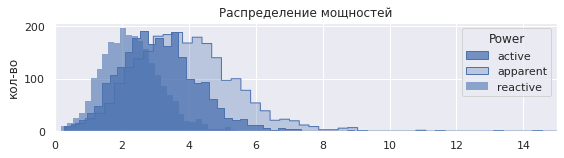

In [49]:
plt.figure(figsize=(9, 2))
fig = sns.histplot(df_general['active power'], 
                   label='active', element="step")
fig = sns.histplot(df_general['reactive power'], 
                   label='reactive', alpha=0.6)
fig = sns.histplot(df_general['apparent power'], 
                   label='apparent', element="step", alpha=0.3)
plt.ylabel('кол-во')
plt.xlabel('')
plt.xlim(0, 15)
plt.title('Распределение мощностей')
plt.legend(title='Power')
plt.show()

### Длительность и энергия нагрева

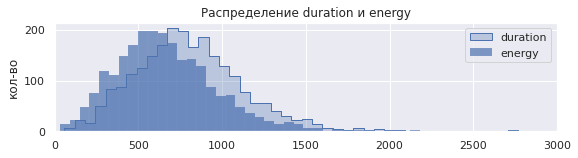

In [50]:
plt.figure(figsize=(9, 2))
fig = sns.histplot(df_general['energy'], 
                   label='energy', alpha=0.7)
fig = sns.histplot(df_general['duration'], 
                   label='duration', element="step", alpha=0.3)
plt.ylabel('кол-во')
plt.xlabel('')
plt.xlim(0, 3000)
plt.title('Распределение duration и energy')
plt.legend()
plt.show()

### Сыпучие материалы

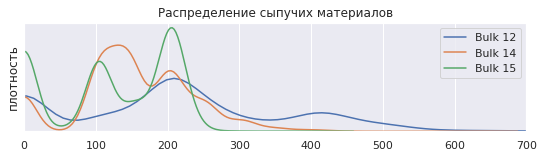

In [51]:
plt.figure(figsize=(9, 2))
fig = sns.kdeplot(df_general['Bulk 12'], label='Bulk 12')
fig = sns.kdeplot(df_general['Bulk 14'], label='Bulk 14')
fig = sns.kdeplot(df_general['Bulk 15'], label='Bulk 15')
plt.yticks([])
plt.ylabel('плотность')
plt.xlabel('')
plt.xlim(0, 700)
plt.title('Распределение сыпучих материалов')
plt.legend()
plt.show()

### Газ и проволочные материалы

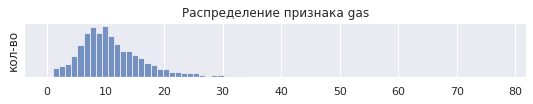

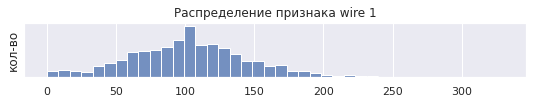

In [52]:
plt.figure(figsize=(9, 1))
fig = sns.histplot(df_general['gas'])
plt.yticks([])
plt.ylabel('кол-во')
plt.xlabel('')
plt.title('Распределение признака gas')
plt.show()
plt.figure(figsize=(9, 1))
fig = sns.histplot(df_general['Wire 1'])
plt.yticks([])
plt.ylabel('кол-во')
plt.xlabel('')
plt.title('Распределение признака wire 1')
plt.show()

### Температура первого нагрева и температура таргет

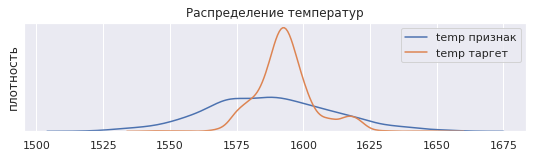

In [53]:
plt.figure(figsize=(9, 2))
fig = sns.kdeplot(df_general['temp'], label='temp признак')
fig = sns.kdeplot(df_general['target temp'], label='temp таргет')
plt.yticks([])
plt.ylabel('плотность')
plt.xlabel('')
plt.title('Распределение температур')
plt.legend()
plt.show()

### Матрица корреляций

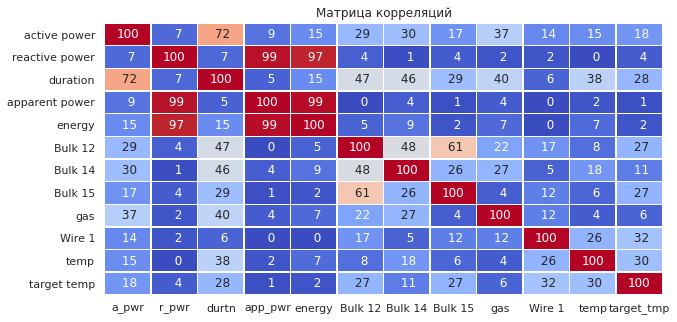

In [54]:
xlabels = ['a_pwr', 'r_pwr', 'durtn', 'app_pwr', 'energy', 'Bulk 12', 
           'Bulk 14', 'Bulk 15', 'gas', 'Wire 1', 'temp', 'target_tmp']
plt.figure(figsize=(10, 5))
sns.heatmap(df_general.corr().abs()*100, annot=True, fmt='3.0f', 
            cmap='coolwarm', cbar=False, linewidths=0.5, 
            xticklabels=xlabels)
plt.xticks(rotation=0)
plt.title('Матрица корреляций')
plt.show()

Видно, что мощности, длительность и энергия нагрева сильно коррелируют между собой. При обучении линейных моделей уберем часть признаков.  
А также видно, что у температуры, которую нам нужно предсказать нет сильной линейной корреляции ни с одним из признаков

# Отбор и обучение моделей

Подготовим выборки для обучения и теста  
Для линейных моделей выборка для обучения будет без сильно коррелирующих признаков

In [55]:
X = df_general.drop('target temp', axis=1)
y = df_general['target temp']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

X_train_lin = X_train.drop(
    ['reactive power', 'apparent power', 'energy'], axis=1)
X_test_lin = X_test.drop(
    ['reactive power', 'apparent power', 'energy'], axis=1)
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (1743, 11)
Test size: (581, 11)


Попробуем 2 линейные модели с регуляризацией Lasso и ElasticNet  
А также модель с использованием градиентного бустинга деревьев

## Lasso

Для линейных моделей нужно сначала масштабировать признаки. Для удобства, будем использовать pipeline

In [56]:
model = Lasso()
scaler = StandardScaler()
pipe = make_pipeline(scaler, model)
params = {
    'lasso__alpha':np.logspace(-2, 1, 100)}
search = GridSearchCV(
    pipe, params, scoring='neg_mean_absolute_error', n_jobs=5)
search.fit(X_train_lin, y_train)
best_score = np.abs(search.best_score_)
print('Best MAE:', '{:.2f}'.format(best_score))
print('Hyperparams:')
search.best_params_

Best MAE: 6.77
Hyperparams:


{'lasso__alpha': 0.12328467394420659}

## ElasticNet

In [57]:
model = ElasticNet()
scaler = StandardScaler()
pipe = make_pipeline(scaler, model)
params = {
    'elasticnet__alpha':np.logspace(-2, 1, 10), 
    'elasticnet__l1_ratio':np.linspace(0.01, 1, 10)}
search = GridSearchCV(
    pipe, params, scoring='neg_mean_absolute_error', n_jobs=5)
search.fit(X_train_lin, y_train)
best_score = np.abs(search.best_score_)
print('Best MAE:', '{:.2f}'.format(best_score))
print('Hyperparams:')
search.best_params_

Best MAE: 6.77
Hyperparams:


{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 1.0}

## LGBMRegressor

In [58]:
model = LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)
params = {
    'max_depth':range(3, 7), 
    'n_estimators':np.linspace(50, 150, 10, dtype='int')}
search = GridSearchCV(
    model, params, scoring='neg_mean_absolute_error', n_jobs=5)
search.fit(X_train, y_train)
best_score = np.abs(search.best_score_)
print('Best MAE:', '{:.2f}'.format(best_score))
print('Hyperparams:')
search.best_params_

Best MAE: 6.66
Hyperparams:


{'max_depth': 4, 'n_estimators': 72}

Лучший результат показала модель с использованием градиентного бустинга, ее и будем использовать на финальном тестировании

---

Посмотрим, важность признаков для лучшей модели, LGBMRegressor  
`importance` - сколько раз модель использовала признак

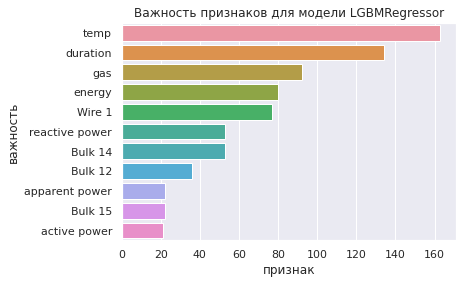

In [59]:
best_estimator = search.best_estimator_
importance = best_estimator.feature_importances_
features_name = df_general.columns[:-1]
df_features_importance = pd.DataFrame(
    {'feature':features_name, 
     'importance':importance})
df_features_importance.sort_values('importance', ascending=False, inplace=True)
sns.barplot(data=df_features_importance, x='importance', y='feature', orient='h')
plt.xlabel('признак')
plt.ylabel('важность')
plt.title('Важность признаков для модели LGBMRegressor')
plt.show()

## Тестирование модели

Протестируем модель на test выборке

In [60]:
model = best_estimator
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_score = mean_absolute_error(y_test, y_pred)
print('Test MAE:', '{:.2f}'.format(test_score))

Test MAE: 6.59


Сравним результат с константной моделью

In [61]:
dummy_reg = DummyRegressor()
y_dummy = dummy_reg.fit(X_train, y_train).predict(X_test)
dummy_score = mean_absolute_error(y_test, y_dummy)
print('Dummy MAE:', '{:.2f}'.format(dummy_score))

Dummy MAE: 8.15


При выборе модели **LGBMRegressor** получили на тестовой выборке **MAE 6.59**  
Результат константной модели - 8.15

---
**Подытог**  
После предобработки данных у нас осталось 2324 объекта, из которых на обучение пошло 1743.  
Из 2-х линейных моделей с регуляризацией Lasso и ElasticNet, а также модели LGBMRegressor наилучшую метрику MAE при кросс-валидации(5 фолдов) показала послденяя модель(результат MAE 6.66)  
На тестовой выборке лучшая модель показала результат **MAE 6.59**  
Результат константной модели - 8.15

## Отчет

Требовалось решить задачу регрессии: создать модель прогнозирования температуры сплава стали на последней итерации цикла плавки.  
Исходные данные - техническая информация для чуть более 3000 циклов плавки.  
Метрика качества - MAE. Она должна быть не выше 6.8.  

**План и решение**  
Работу получилось выполнить почти в соответсвии с намеченным планом. Единственным отклонением было решение не удалять выбросы из итогового датасета(по согласованию с тимлидом)

1. Загрузка данных
2. Исследуем каждый датасет
    * Общая информация
    * Описательные статистики
    * Распределение признаков
3. Предобработка
    * Убираем из датасетов аномалии
    * Заполняем пропуски нулями
    * Генерируем новые признаки
    * Получаем температуру-признак и температуру-таргет
    * Объединяем датасеты в один датафрейм
    * Исследуем итоговый датафрейм(корреляция признаков)
4. Выбор и проверка моделей
    * Выбираем несколько моделей для изучения
    * Если нужно масштабировать данные, делаем pipeline
    * Подбираем гиперпараметры(gridsearch)
    * Если подбирать гиперпараметры не нужно, используем cross_val_score
    * Отбираем лучшую модель (лучший средний результат на кросс-валидации)
    * Исследуем важность признаков
5. Тестируем итоговую модель
    * Тестируем лучшую модель на test выборке
    * Сравниваем модель с константной
---  

**Трудности проекта**  
Главной трудностью проекта была правильная предобработка данных и отбор признака для обучения.  
Отбор признаков был сделан на основе анализа пропущенных значений, а также матрицы корреляций.  
Помощь с правильной предобработкой данных была получена от тимлида.  


**Подготовка данных**  
Из всех датафреймов `data_arc` и `data_temp` были удалены аномалии. Были сгенерированны новые признаки(длительность и энергия нагрева). В датафреймах `data_arc` и `data_temp` данные для каждого цикла плавки были агрегированы для получения вектора признаков. В датафреймах `data_bulk` и `data_wire` отсутствующие данные были заменены на ноль по информации от заказчика, а также, удалены наименее информативные признаки(нулевых значений > 50%). Из `data_temp` была получена температура нагрева на первой(используется как признак) и последней(используется как таргет) итерации цикла плавки.  
При объединении признаков в итоговый датафрейм попадали только те партии(поле `key`), информация о которых была во всех датафреймах одновременно. Это требование заказчика(если на каком-либо этапе нет инормации или она неверна - вся партия считается дефектной).  
Также, была изучена матрица корреляции признаков. Между собой ожидаемо сильно коррелируют признаки: активная, реактивная, полная мощности, а также энергия нагрева.  

**Отбор и обучение моделей**  
Итоговый датафрейм был разделен на выборки для обучения и тестирования в соотношении 75:25.  
Были обучены 2 линейные модели с регуляризацией Lasso и ElasticNet, а также модель с использованием градиентного бустинга деревьев LGBMRegressor.  
Для линейных моделей использовался pipeline, в котором первым шагом было масштабирование признаков(StandardScaler), а вторым уже обучение модели.  
Также, для линеных моделей из выборки для обучения были убраны признаки `reactive power`, `apparent power`и `energy` из-за сильной корреляции.  
Для всех трех моделей подбирались оптимальные гиперпараметры(GridSearch) с кросс-валидацией на 5 фолдах.  
Lasso и ElasticNet получили результаты MAE **6.77**, а лучшая модель, LGBMRegressor **6.66**. Гиперпараметры лучшей модели: max_depth=3, n_estimators=100, random_state=110923.  
Топ 3 важных признака для модели - это *temp*, *duration* и *gas*  

**Список признаков для обучения модели**  
А весь список признаков для обучения модели с предобработкой выглядел так:
 * `active power` и `reactive power` получены агрегированием (суммирование внутри одного цикла плавки)  
   `apparent powet`, `duration` и `energy` были сгенерированы, плюс агрегирование
 * `Wire 1`, `Bulk 12`,  `Bulk 14` и `Bulk 14` - пропущенные значения заменены на 0
 * `Gas` - без изменений
 * `temp` получена агрегированием (первое вхождение температуры для каждого цикла плавки), убрана аномально низкая температура (<1450)

**Итоговая метрика**  
На выборке для тестирования лучшая модель(LGBMRegressor, max_depth=4, n_estimators=72, random_state=110923) показала результат **MAE 6.59**, что удовлетворяет требованию заказчика.  
Для константной модели метрика MAE составила 8.15. 

**Как можно улучшить результат?**  
Попробовать включать в выборку для обучения различные комбинации признаков из `data_bulk` и `data_wire`, даже те, где большинство значений 0.  
И попробовать другие линейные модели, более устойчивые к выбросам